# Лабораторная работа #1: Рекуррентные нейронные сети

## Задача 1: PoS-tagging

В данной лабораторной работе будут использоваться корпуса проекта Universal Dependencies: http://universaldependencies.org/

Непосредственно корпуса можно скачать по адресу: https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-2515

### Часть I Работа с корпусом CoNLL
В этой части предусматривается работа с корпусом CoNLL - предварительная обработка, чтение и парсинг корпуса, а также определение размера словаря.
Считайте из файла данные и получите статистику:
* Размер самого длинного предложения;
* Количество предложений в корпусе;
* Уникальное число слов в словаре;
* Уникальное число меток;

Для **удобной** работы с CoNLL разметкой предлагается использовать библиотеку: https://github.com/EmilStenstrom/conllu

Но это отнюдь не означает, что вы не можете написать ваш собственный парсер.

In [123]:
from conllu.parser import parse, parse_tree
from collections import Counter
import numpy as np


import matplotlib.pyplot as plt
from keras.layers.core import Activation, Dense, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import np_utils

Задаем имена файлов с тренировочным и тестовым наборами:

In [206]:
train_conll_fname = 'ga-ud-train.conllu'
test_conll_fname = 'ga-ud-test.conllu'       

Функция 
    parsed_sentences
читает conll файл, и проводит его обработку, подсчитывая:
* sents_word - список списков словоформ (внешний список - предложения, внутренний список - слова в этом предложении);
* word_frequencies - коллекция типа Counter для подсчета частоты словоформ
* sents_pos - список списов PoS тегов (соответствующих словам из sents_word);
* pos_frequencies - коллекция типа Counter для подсчета частоты PoS-тегов.

In [124]:

def parsed_sentences(conll_fname):
    conll_file = open(conll_fname, 'r', encoding='utf-8')
    conll_data = conll_file.read()
    conll_file.close()
    
    sents_word = []
    word_frequencies = Counter()
    
    sents_pos = []
    pos_frequencies = Counter()

    for current_parsed_sentence in parse(conll_data):
        current_sentence_words = []
        current_sentence_pos = []        
        for separated_parsed_words in current_parsed_sentence:
            current_sentence_words.append(separated_parsed_words['form'])
            word_frequencies[separated_parsed_words['form']] += 1
            current_sentence_pos.append(separated_parsed_words['upostag'])
            pos_frequencies[separated_parsed_words['upostag']] += 1
        
        sents_word.append(current_sentence_words)
        sents_pos.append(current_sentence_pos)

    return (sents_word, word_frequencies,
           sents_pos, pos_frequencies)


Считываем файлы тренировочной и тестовой выборки, и формируем (для каждого свою) наборы 
* sents_word
* word_frequencies
* sents_pos
* pos_frequencies

In [126]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

Выведете статистику, для тренировочной и тестовой выборки
Статистика должна отражать:
* Число предложений;
* Число словоформ;
* Число уникальных PoS тегов;
* Максимальное число слов в предложении;
* Минимальное число слов в предложении;
* Среднее арифметическое и среднее медианное число слов в предложении;
* Доля пересечения словоформ в тестовой и тренировочной выборке;

In [ ]:
print("Stats: ")

train_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in sents_word])
test_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in test_sents_word])

print("Train set: \n\tCount sentences: {} \n\tUnique words: {}".format(len(sents_word), len(word_frequencies)))
print("\tUnique PoS tags: {}".format(len(pos_frequencies)))
print("\tMax count words in sentences: {}".format(np.max(train_length_of_sentences_list))
print("\tMin count words in sentence: {}".format(np.min(train_length_of_sentences_list)))
# Дополните самостоятельно

На основании полученных Вами данных примите решения, касающиеся ключевых параметров нейронной сети:
* Максимальная длина последовательности (MAX_SEQLEN);
* Максимальное количество атрибутов (S_MAX_FEATURES);
* Максимальное количество тегов (T_MAX_FEATURES);

**Замечание**: *MAX_SEQLEN* не обязательно должна равна максимальному числу слов в предложении, особенно если встречается всего 1 такое предложение.

In [ ]:
MAX_SEQLEN = 
S_MAX_FEATURES = 
T_MAX_FEATURES = 

Объясните свой выбор целевых параметров:
* MAX_SEQLEN  
* S_MAX_FEATURES 
* T_MAX_FEATURES 

Параметры по умолчанию для числа нейронов в скрытом слое, объема пространства погружения и размера пакета.

Можно использовать стандартные, можно поиграться с ними.

In [180]:
EMBED_SIZE = 300
HIDDEN_SIZE = 100

BATCH_SIZE = 64

Задайте число эпох и итераций:

In [197]:
NUM_EPOCHS = 
NUM_ITERATIONS = 

Как и в большинстве других задач глубокого обучения, каждая строчка должна быть закодирована индексами слов. Кроме того, выход (PoS-теги) должны быть последовательностями индексов PoS-тегов.
Поэтомк, мы создаем табличцы для перевода слов/PoS-тегов в соответствующие индексы.
Словарь словоформ должен иметь 2 дополнительных метки:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Кроме того, захотим проиллюстрировать PoS-теггер, поэтому нужно составить таблицы для поиска словоформ и частеречевых тегов.
Ниже показано задание таблиц.

Составляем таблицу поиска для словоформ:

In [ ]:
s_vocabsize = min(len(word_frequencies), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(word_frequencies.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

Таблицу поиска частеречевых меток предлагается создать самостоятельно:

**Замечание: ** для PoS-тегов элемент UNK не нужен, поскольку список частей речи уже известен. Элемент PAD нужен.

In [ ]:
t_vocabsize = 
t_word2index = 

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.

**Задание: **
* Построить четыре модели нейронной сети:
    * SimpleRNN
    * LSTM
    * Bidirectional
    * GRU

In [198]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

Объясните необходимость использования в качестве функции потерь категориальную энтропию
**Ответ**:

Выведите архитектуру сети посредством метода summary() модели Keras.

In [199]:
LSTM_POS_TAGGER = build_pos_tagger_LSTM()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 300)           1436100   
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               160400    
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 50, 100)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 50, 17)            1717      
_________________________________________________________________
activation_9 (Activation)    (None, 50, 17)            0         
Total params: 1,678,617
Trainable params: 1,678,617
Non-trainable params: 0
_________________________________________________________________


Подсчитаем объем количества батчей для тренировочной и тестовой выборки, кроме того, сделаем функцию для получения генератора батчей.

In [200]:
num_train_samples = len(sents_word) // BATCH_SIZE
num_test_samples = len(test_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = np_utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 11
	V of test samples: 2


Инициализируем генераторы для тренировочной и тестовой выборки. 

In [202]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

Обновляем списки с историями для точности, функции потерь на тренировочной и тестовой выборках:

In [203]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [204]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/50
11/11 [==============================] - 5s - loss: 2.5812 - acc: 0.5259 - val_loss: 2.1456 - val_acc: 0.5330
Epoch 2/50
11/11 [==============================] - 2s - loss: 1.7940 - acc: 0.5797 - val_loss: 1.6689 - val_acc: 0.5680
Epoch 3/50
11/11 [==============================] - 2s - loss: 1.5928 - acc: 0.5824 - val_loss: 1.5964 - val_acc: 0.5695
Epoch 4/50
11/11 [==============================] - 2s - loss: 1.4852 - acc: 0.6099 - val_loss: 1.4739 - val_acc: 0.5873
Epoch 5/50
11/11 [==============================] - 3s - loss: 1.3041 - acc: 0.6378 - val_loss: 1.2367 - val_acc: 0.6453
Epoch 6/50
11/11 [==============================] - 2s - loss: 1.2939 - acc: 0.6344 - val_loss: 1.2952 - val_acc: 0.6464
Epoch 7/50
11/11 [==============================] - 2s - loss: 1.1897 - acc: 0.6605 - val_loss: 1.1898 - val_acc: 0.6533
Epoch 8/50
11/11 [==============================] - 2s - loss: 1.1429 - acc: 0.6626 - val_loss: 1.1953 - val_acc: 0.6450
Epoch 9/50
11/11 [==============

11/11 [==============================] - 2s - loss: 0.9376 - acc: 0.6983 - val_loss: 1.0527 - val_acc: 0.6691
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.9285 - acc: 0.7026 - val_loss: 1.0552 - val_acc: 0.6727
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.9324 - acc: 0.6981 - val_loss: 1.0165 - val_acc: 0.6877
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.9175 - acc: 0.7048 - val_loss: 1.0444 - val_acc: 0.6723
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.9109 - acc: 0.7049 - val_loss: 1.0129 - val_acc: 0.6872
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.9385 - acc: 0.6974 - val_loss: 1.0276 - val_acc: 0.6700
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.9182 - acc: 0.7024 - val_loss: 1.0041 - val_acc: 0.6841
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.9438 - acc: 0.6934 - val_loss: 1.1843 - val_acc: 0.6206
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.8427 - acc: 0.7133 - val_loss: 1.0332 - val_acc: 0.6828
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.8304 - acc: 0.7164 - val_loss: 1.0404 - val_acc: 0.6780
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.8144 - acc: 0.7229 - val_loss: 1.0837 - val_acc: 0.6659
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.8235 - acc: 0.7182 - val_loss: 1.0612 - val_acc: 0.6734
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.8101 - acc: 0.7234 - val_loss: 1.0524 - val_acc: 0.6764
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.8231 - acc: 0.7180 - val_loss: 1.0855 - val_acc: 0.6650
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.8215 - acc: 0.7179 - val_loss: 1.0547 - val_acc: 0.6827
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.8143 - acc: 0.7203 - val_loss: 1.0407 - val_acc: 0.6791
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 3s - loss: 0.7301 - acc: 0.7393 - val_loss: 1.0815 - val_acc: 0.6655
Epoch 2/50
11/11 [==============================] - 3s - loss: 0.7321 - acc: 0.7363 - val_loss: 1.1341 - val_acc: 0.6528
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.7553 - acc: 0.7284 - val_loss: 1.1799 - val_acc: 0.6392
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.7387 - acc: 0.7319 - val_loss: 1.1709 - val_acc: 0.6475
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.7920 - acc: 0.7127 - val_loss: 1.1729 - val_acc: 0.6506
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.8089 - acc: 0.7111 - val_loss: 1.0978 - val_acc: 0.6658
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.8121 - acc: 0.7103 - val_loss: 1.1232 - val_acc: 0.6627
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.7697 - acc: 0.7224 - val_loss: 1.0284 - val_acc: 0.6866
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.6547 - acc: 0.7532 - val_loss: 1.1801 - val_acc: 0.6539
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.6865 - acc: 0.7439 - val_loss: 1.1496 - val_acc: 0.6631
Epoch 3/50
11/11 [==============================] - 3s - loss: 0.6632 - acc: 0.7508 - val_loss: 1.1512 - val_acc: 0.6656
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.6853 - acc: 0.7425 - val_loss: 1.1605 - val_acc: 0.6589
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.6716 - acc: 0.7440 - val_loss: 1.1386 - val_acc: 0.6722
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.7100 - acc: 0.7324 - val_loss: 1.1540 - val_acc: 0.6611
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.6747 - acc: 0.7449 - val_loss: 1.1767 - val_acc: 0.6602
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.6778 - acc: 0.7460 - val_loss: 1.1294 - val_acc: 0.6686
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.6119 - acc: 0.7628 - val_loss: 1.2578 - val_acc: 0.6398
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.6050 - acc: 0.7688 - val_loss: 1.2707 - val_acc: 0.6539
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.6224 - acc: 0.7597 - val_loss: 1.1496 - val_acc: 0.6912
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.6078 - acc: 0.7675 - val_loss: 1.2208 - val_acc: 0.6625
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.5922 - acc: 0.7740 - val_loss: 1.2472 - val_acc: 0.6570
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.6150 - acc: 0.7622 - val_loss: 1.1691 - val_acc: 0.6811
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.6093 - acc: 0.7622 - val_loss: 1.2576 - val_acc: 0.6541
Epoch 9/50
11/11 [==============================] - 2s - loss: 0.6270 - acc: 0.7576 - val_loss: 1.2569 - val_acc: 0.6550
Epoch 10/50
11/11 [========================

11/11 [==============================] - 2s - loss: 0.5769 - acc: 0.7743 - val_loss: 1.3469 - val_acc: 0.6517
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.5702 - acc: 0.7792 - val_loss: 1.3250 - val_acc: 0.6525
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.5721 - acc: 0.7764 - val_loss: 1.3741 - val_acc: 0.6380
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.5938 - acc: 0.7651 - val_loss: 1.3296 - val_acc: 0.6502
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.5542 - acc: 0.7839 - val_loss: 1.2784 - val_acc: 0.6709
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.5348 - acc: 0.7955 - val_loss: 1.3725 - val_acc: 0.6512
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.5812 - acc: 0.7743 - val_loss: 1.3995 - val_acc: 0.6428
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.5642 - acc: 0.7737 - val_loss: 1.3338 - val_acc: 0.6598
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.5047 - acc: 0.8049 - val_loss: 1.3928 - val_acc: 0.6573
Epoch 2/50
11/11 [==============================] - 3s - loss: 0.5282 - acc: 0.7928 - val_loss: 1.3425 - val_acc: 0.6678
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.5350 - acc: 0.7907 - val_loss: 1.3807 - val_acc: 0.6698
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.5129 - acc: 0.7977 - val_loss: 1.4441 - val_acc: 0.6520
Epoch 5/50
11/11 [==============================] - 3s - loss: 0.5143 - acc: 0.7981 - val_loss: 1.4975 - val_acc: 0.6325
Epoch 6/50
11/11 [==============================] - 3s - loss: 0.5031 - acc: 0.8070 - val_loss: 1.3689 - val_acc: 0.6734
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.5271 - acc: 0.7950 - val_loss: 1.4060 - val_acc: 0.6573
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.5368 - acc: 0.7872 - val_loss: 1.4378 - val_acc: 0.6447
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.4969 - acc: 0.7972 - val_loss: 1.4614 - val_acc: 0.6669
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.5000 - acc: 0.7948 - val_loss: 1.5373 - val_acc: 0.6523
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.5257 - acc: 0.7849 - val_loss: 1.6077 - val_acc: 0.6461
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.6203 - acc: 0.7481 - val_loss: 1.5572 - val_acc: 0.6355
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.5365 - acc: 0.7801 - val_loss: 1.5132 - val_acc: 0.6447
Epoch 6/50
11/11 [==============================] - 3s - loss: 0.5246 - acc: 0.7851 - val_loss: 1.4701 - val_acc: 0.6561
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.5120 - acc: 0.7925 - val_loss: 1.4657 - val_acc: 0.6641
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.4743 - acc: 0.8132 - val_loss: 1.4866 - val_acc: 0.6589
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 3s - loss: 0.5296 - acc: 0.7808 - val_loss: 1.5072 - val_acc: 0.6700
Epoch 2/50
11/11 [==============================] - 3s - loss: 0.4950 - acc: 0.7957 - val_loss: 1.5245 - val_acc: 0.6623
Epoch 3/50
11/11 [==============================] - 3s - loss: 0.4879 - acc: 0.8038 - val_loss: 1.6099 - val_acc: 0.6505
Epoch 4/50
11/11 [==============================] - 3s - loss: 0.4298 - acc: 0.8312 - val_loss: 1.5742 - val_acc: 0.6608
Epoch 5/50
11/11 [==============================] - 3s - loss: 0.4435 - acc: 0.8280 - val_loss: 1.6845 - val_acc: 0.6197
Epoch 6/50
11/11 [==============================] - 3s - loss: 0.4496 - acc: 0.8270 - val_loss: 1.4865 - val_acc: 0.6813
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.4393 - acc: 0.8292 - val_loss: 1.7490 - val_acc: 0.6280
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.4467 - acc: 0.8260 - val_loss: 1.5662 - val_acc: 0.6613
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.5383 - acc: 0.7792 - val_loss: 1.7049 - val_acc: 0.6431
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.5891 - acc: 0.7644 - val_loss: 1.7330 - val_acc: 0.6488
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.5406 - acc: 0.7804 - val_loss: 1.6324 - val_acc: 0.6605
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.5056 - acc: 0.7945 - val_loss: 1.7146 - val_acc: 0.6458
Epoch 5/50
11/11 [==============================] - 3s - loss: 0.4605 - acc: 0.8125 - val_loss: 1.6857 - val_acc: 0.6525
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.4295 - acc: 0.8301 - val_loss: 1.7516 - val_acc: 0.6438
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.4407 - acc: 0.8239 - val_loss: 1.7061 - val_acc: 0.6569
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.4151 - acc: 0.8335 - val_loss: 1.7586 - val_acc: 0.6414
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.4074 - acc: 0.8362 - val_loss: 1.6894 - val_acc: 0.6803
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.3950 - acc: 0.8454 - val_loss: 1.8149 - val_acc: 0.6459
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.3833 - acc: 0.8538 - val_loss: 1.9425 - val_acc: 0.6178
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3807 - acc: 0.8555 - val_loss: 1.7753 - val_acc: 0.6528
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.3723 - acc: 0.8588 - val_loss: 1.8243 - val_acc: 0.6509
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.3764 - acc: 0.8551 - val_loss: 1.9572 - val_acc: 0.6270
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.3728 - acc: 0.8584 - val_loss: 1.7930 - val_acc: 0.6517
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.3792 - acc: 0.8553 - val_loss: 1.8963 - val_acc: 0.6408
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 3s - loss: 0.3685 - acc: 0.8593 - val_loss: 1.9162 - val_acc: 0.6469
Epoch 2/50
11/11 [==============================] - 3s - loss: 0.3857 - acc: 0.8487 - val_loss: 1.8225 - val_acc: 0.6647
Epoch 3/50
11/11 [==============================] - 3s - loss: 0.5574 - acc: 0.7780 - val_loss: 1.9795 - val_acc: 0.6448
Epoch 4/50
11/11 [==============================] - 3s - loss: 0.4708 - acc: 0.8088 - val_loss: 1.9411 - val_acc: 0.6491
Epoch 5/50
11/11 [==============================] - 3s - loss: 0.4538 - acc: 0.8142 - val_loss: 1.7948 - val_acc: 0.6636
Epoch 6/50
11/11 [==============================] - 3s - loss: 0.4525 - acc: 0.8142 - val_loss: 1.9543 - val_acc: 0.6409
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.4197 - acc: 0.8305 - val_loss: 1.9051 - val_acc: 0.6555
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.3759 - acc: 0.8522 - val_loss: 1.9610 - val_acc: 0.6388
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.4517 - acc: 0.8115 - val_loss: 1.9829 - val_acc: 0.6509
Epoch 2/50
11/11 [==============================] - 3s - loss: 0.4431 - acc: 0.8176 - val_loss: 1.9941 - val_acc: 0.6484
Epoch 3/50
11/11 [==============================] - 3s - loss: 0.4208 - acc: 0.8257 - val_loss: 2.1076 - val_acc: 0.6213
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3717 - acc: 0.8512 - val_loss: 2.0351 - val_acc: 0.6434
Epoch 5/50
11/11 [==============================] - 3s - loss: 0.4010 - acc: 0.8350 - val_loss: 1.9388 - val_acc: 0.6641
Epoch 6/50
11/11 [==============================] - 3s - loss: 0.3530 - acc: 0.8601 - val_loss: 2.0038 - val_acc: 0.6475
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.3492 - acc: 0.8656 - val_loss: 2.0010 - val_acc: 0.6533
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.3397 - acc: 0.8707 - val_loss: 1.9432 - val_acc: 0.6728
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.2794 - acc: 0.8995 - val_loss: 2.0780 - val_acc: 0.6523
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.3053 - acc: 0.8882 - val_loss: 2.0679 - val_acc: 0.6578
Epoch 3/50
11/11 [==============================] - 3s - loss: 0.2970 - acc: 0.8907 - val_loss: 2.1222 - val_acc: 0.6452
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3104 - acc: 0.8867 - val_loss: 2.0991 - val_acc: 0.6522
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.3132 - acc: 0.8832 - val_loss: 2.1182 - val_acc: 0.6469
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.2911 - acc: 0.8951 - val_loss: 2.1344 - val_acc: 0.6511
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.3003 - acc: 0.8894 - val_loss: 2.0917 - val_acc: 0.6542
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.3123 - acc: 0.8853 - val_loss: 2.1310 - val_acc: 0.6494
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.2971 - acc: 0.8890 - val_loss: 2.0407 - val_acc: 0.6703
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.2904 - acc: 0.8920 - val_loss: 2.2562 - val_acc: 0.6436
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.2919 - acc: 0.8934 - val_loss: 2.2602 - val_acc: 0.6419
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.2724 - acc: 0.9022 - val_loss: 2.1037 - val_acc: 0.6538
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.2836 - acc: 0.8964 - val_loss: 2.1190 - val_acc: 0.6681
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.2841 - acc: 0.8949 - val_loss: 2.0981 - val_acc: 0.6608
Epoch 7/50
11/11 [==============================] - 3s - loss: 0.3086 - acc: 0.8833 - val_loss: 2.1757 - val_acc: 0.6458
Epoch 8/50
11/11 [==============================] - 3s - loss: 0.2855 - acc: 0.8911 - val_loss: 2.1315 - val_acc: 0.6639
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.2697 - acc: 0.9000 - val_loss: 2.2075 - val_acc: 0.6617
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.3051 - acc: 0.8849 - val_loss: 2.2278 - val_acc: 0.6600
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.2858 - acc: 0.8920 - val_loss: 2.2841 - val_acc: 0.6445
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3099 - acc: 0.8824 - val_loss: 2.2481 - val_acc: 0.6519
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.2826 - acc: 0.8938 - val_loss: 2.2521 - val_acc: 0.6550
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.2981 - acc: 0.8877 - val_loss: 2.2909 - val_acc: 0.6473
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.2589 - acc: 0.9038 - val_loss: 2.3218 - val_acc: 0.6461
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.2830 - acc: 0.8966 - val_loss: 2.3637 - val_acc: 0.6375
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.6583 - acc: 0.7740 - val_loss: 2.4580 - val_acc: 0.6281
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.5745 - acc: 0.7852 - val_loss: 2.3198 - val_acc: 0.6361
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.4638 - acc: 0.8128 - val_loss: 2.1937 - val_acc: 0.6570
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3983 - acc: 0.8379 - val_loss: 2.0889 - val_acc: 0.6702
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.3295 - acc: 0.8665 - val_loss: 2.2852 - val_acc: 0.6500
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.3199 - acc: 0.8762 - val_loss: 2.2969 - val_acc: 0.6544
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.2825 - acc: 0.8940 - val_loss: 2.3351 - val_acc: 0.6456
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.2794 - acc: 0.8993 - val_loss: 2.2088 - val_acc: 0.6612
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.3486 - acc: 0.8624 - val_loss: 2.4698 - val_acc: 0.6433
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.4018 - acc: 0.8399 - val_loss: 2.4574 - val_acc: 0.6353
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.3597 - acc: 0.8557 - val_loss: 2.4873 - val_acc: 0.6331
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.3182 - acc: 0.8738 - val_loss: 2.4614 - val_acc: 0.6416
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.3270 - acc: 0.8726 - val_loss: 2.4601 - val_acc: 0.6342
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.2782 - acc: 0.8936 - val_loss: 2.3974 - val_acc: 0.6511
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.2686 - acc: 0.8994 - val_loss: 2.4229 - val_acc: 0.6441
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.2938 - acc: 0.8893 - val_loss: 2.5401 - val_acc: 0.6280
Epoch 9/50
11/11 [=========================

11/11 [==============================] - 2s - loss: 0.2381 - acc: 0.9152 - val_loss: 2.4831 - val_acc: 0.6464
Epoch 2/50
11/11 [==============================] - 2s - loss: 0.2414 - acc: 0.9127 - val_loss: 2.5162 - val_acc: 0.6442
Epoch 3/50
11/11 [==============================] - 2s - loss: 0.2483 - acc: 0.9103 - val_loss: 2.2063 - val_acc: 0.6842
Epoch 4/50
11/11 [==============================] - 2s - loss: 0.2281 - acc: 0.9174 - val_loss: 2.5798 - val_acc: 0.6384
Epoch 5/50
11/11 [==============================] - 2s - loss: 0.2295 - acc: 0.9176 - val_loss: 2.4519 - val_acc: 0.6470
Epoch 6/50
11/11 [==============================] - 2s - loss: 0.2640 - acc: 0.9024 - val_loss: 2.4380 - val_acc: 0.6583
Epoch 7/50
11/11 [==============================] - 2s - loss: 0.2425 - acc: 0.9127 - val_loss: 2.6939 - val_acc: 0.6202
Epoch 8/50
11/11 [==============================] - 2s - loss: 0.2327 - acc: 0.9143 - val_loss: 2.3576 - val_acc: 0.6763
Epoch 9/50
11/11 [=========================

Постройте и выведите графики функции потерь и точности на тренировочной и тестовой выборке.
Можете воспользоваться заготовкой ниже - заполнив недостающие элементы (с примером), или написать свою

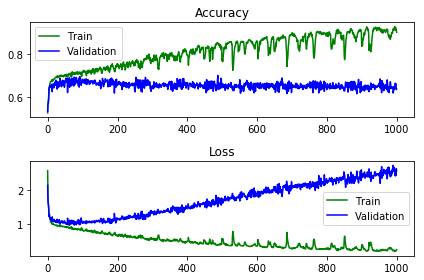

In [205]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
# Здесь ваш код :)

plt.subplot(212)
plt.title("Loss")
# Здесь ваш код :)

plt.tight_layout()
plt.show()